# 452 - Machine Learning - HW7 - Books Recommender System

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#Importing-packages-and-data" data-toc-modified-id="Importing-packages-and-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing packages and data</a></span></li><li><span><a href="#Exploratory-Data-Analyses" data-toc-modified-id="Exploratory-Data-Analyses-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exploratory Data Analyses</a></span></li><li><span><a href="#Building-the-Recommender-system" data-toc-modified-id="Building-the-Recommender-system-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Building the Recommender system</a></span></li></ul></div>

### Overview

The task is to create a Recommendation system for Books based on user ratings. This system will be built using the Surprise package from sci-kit library which is based on collaborative filtering.

Book-Crossings is a book ratings dataset compiled by Cai-Nicolas Ziegler based on data from bookcrossing.com. It contains 1.1 million ratings of 270,000 books by 90,000 users. The ratings are on a scale from 1 to 10, and implicit ratings are also included.

The dataset consists of 3 files -
- User Ratings for Books
- Book details
- User details

### Importing packages and data

In [29]:
# For data loading and manipulation
import pandas as pd
import numpy as np

# For visulaization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For building the recommender system
from surprise import Reader, Dataset, SVD, SVDpp, evaluate

# For image display
import glob
import random
import base64
from PIL import Image
from io import BytesIO
from IPython.display import HTML

In [6]:
# Reading the Book Ratings dataset
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['UserID', 'ISBN', 'Rating']
print(ratings.info())
print(ratings.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
UserID    1149780 non-null int64
ISBN      1149780 non-null object
Rating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None
   UserID        ISBN  Rating
0  276725  034545104X       0
1  276726  0155061224       5
2  276727  0446520802       0
3  276729  052165615X       3
4  276729  0521795028       6


In [7]:
# Reading the books dataset for details on each ISBN
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'Title', 'Author', 'YrOfPublication', 'Publisher', 'ImageUrlS', 'ImageUrlM', 'ImageUrlL']
print(books.info())
print(books.head())

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:271

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
ISBN               271360 non-null object
Title              271360 non-null object
Author             271360 non-null object
YrOfPublication    271360 non-null object
Publisher          271358 non-null object
ImageUrlS          271360 non-null object
ImageUrlM          271360 non-null object
ImageUrlL          271357 non-null object
dtypes: object(8)
memory usage: 16.6+ MB
None
         ISBN                                              Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

                 Author YrOfPublication                   Publisher  \
0    Mark P. O. Morford     

In [8]:
# Reading the users dataset for information about each user
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['UserID', 'Location', 'Age']
print(users.info())
print(users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
UserID      278858 non-null int64
Location    278858 non-null object
Age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None
   UserID                            Location   Age
0       1                  nyc, new york, usa   NaN
1       2           stockton, california, usa  18.0
2       3     moscow, yukon territory, russia   NaN
3       4           porto, v.n.gaia, portugal  17.0
4       5  farnborough, hants, united kingdom   NaN


### Exploratory Data Analyses

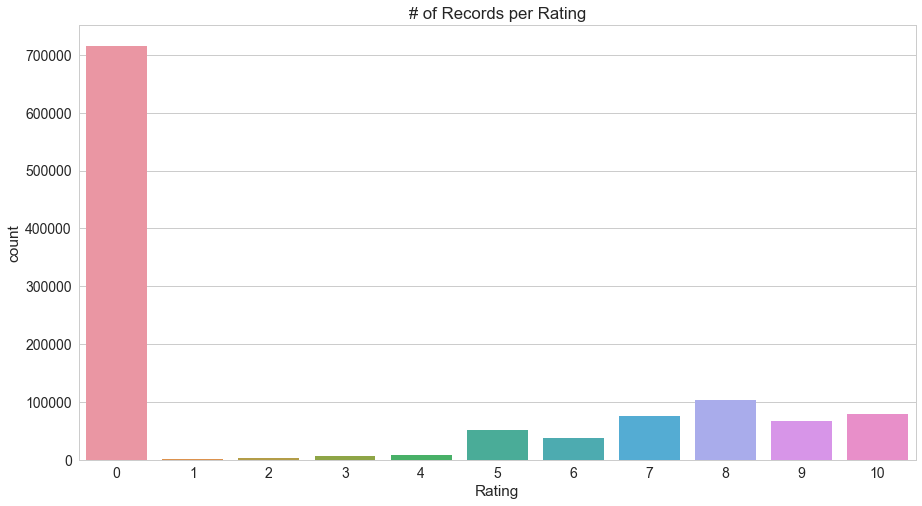

In [9]:
# Check the overall distribution of the ratings
sns.set(style = "whitegrid", font_scale=1.4)
plt.subplots(figsize = (15,8))
sns.countplot("Rating", data=ratings).set_title("# of Records per Rating")

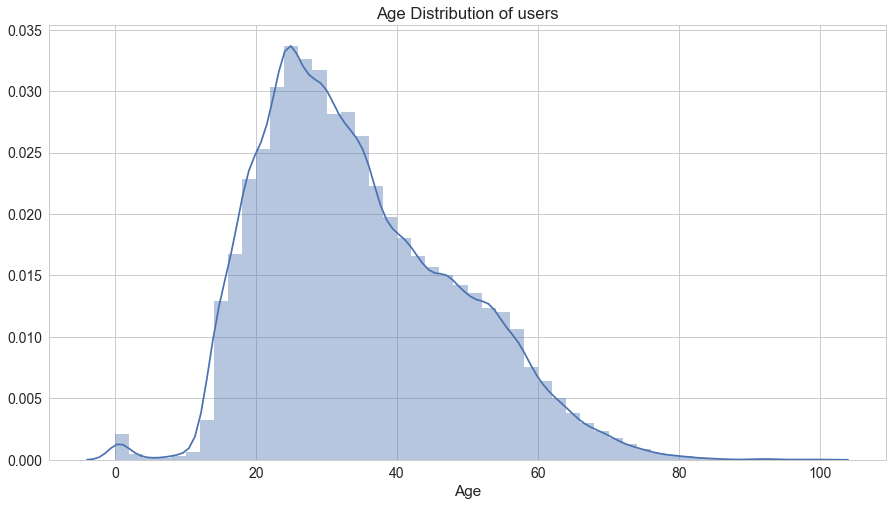

In [10]:
# Check the distribution of the Age of the users
users_nonan = users.dropna(axis=0, how='any')
plt.subplots(figsize = (15,8))
sns.distplot(users_nonan[(users_nonan['Age'] <= 100)]['Age']).set_title("Age Distribution of users")

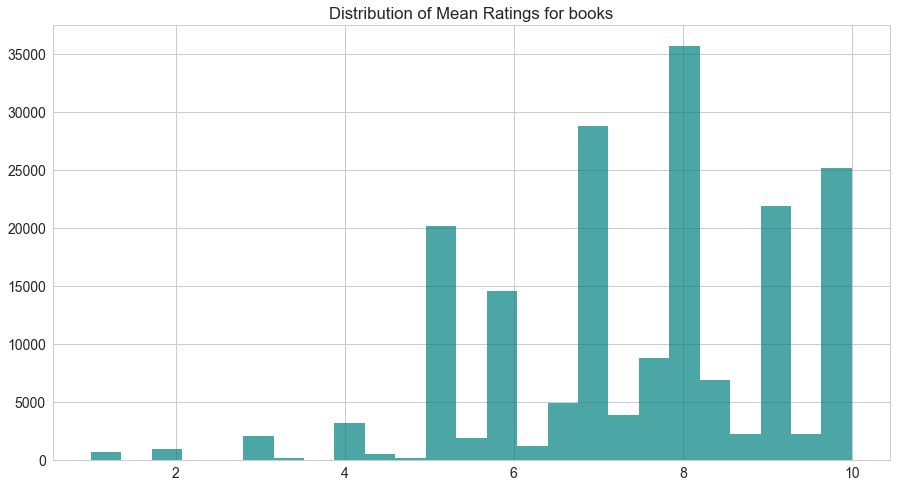

In [11]:
# Let's check the mean ratings for each book (remove the bad ones with 0) and how is that distributed
plt.subplots(figsize = (15,8))
ratings[(ratings['Rating']>=1)].groupby('ISBN')['Rating'].mean().hist(color='teal', alpha=0.7, bins=25).set_title("Distribution of Mean Ratings for books")

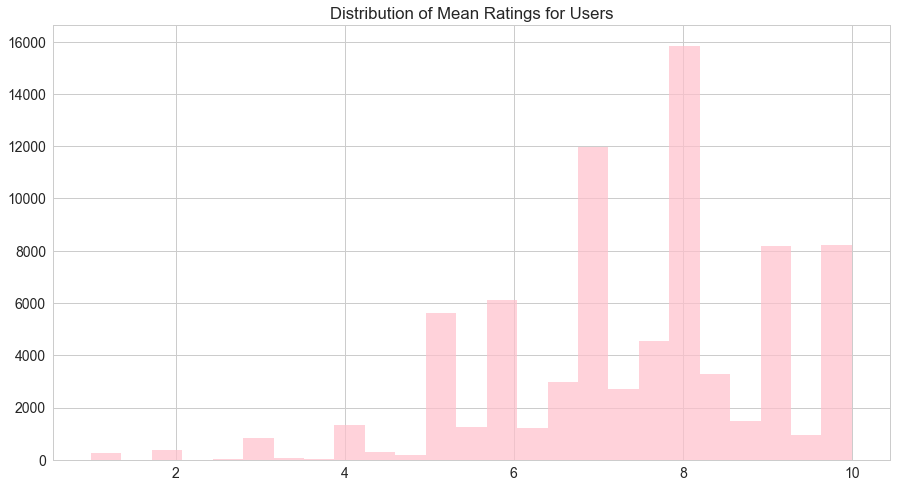

In [12]:
# Let's check the mean ratings for each book (remove the bad ones with 0) and how is that distributed
plt.subplots(figsize = (15,8))
ratings[(ratings['Rating']>=1)].groupby('UserID')['Rating'].mean().hist(color='pink', alpha=0.7, bins=25).set_title("Distribution of Mean Ratings for Users")

In [13]:
# Let us check if there is a correlation between number of rating and average rating of a book
isbn_df = ratings.groupby('ISBN', as_index=False).agg({'UserID':'count','Rating':'mean'})
isbn_df.columns = ['ISBN', 'NumberOfRatings','AverageRating']
isbn_df.head()

,ISBN,NumberOfRatings,AverageRating
0,0330299891,2,3.0
1,0375404120,2,1.5
2,0586045007,1,0.0
3,9022906116,2,3.5
4,9032803328,1,0.0


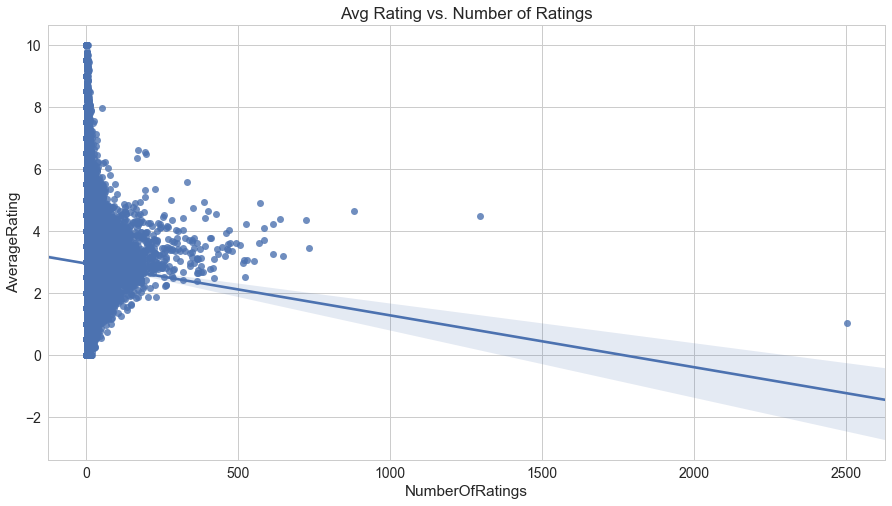

In [15]:
plt.subplots(figsize = (15,8))
sns.regplot(x="NumberOfRatings", y="AverageRating", data=isbn_df).set_title("Avg Rating vs. Number of Ratings")

Let us check the books which are extreme points above and have more than 1000 ratings yet not a great average rating.

In [18]:
# Filtering out the ISBNs and getting info from the books dataset
extrm_isbn = isbn_df[(isbn_df['NumberOfRatings']>1000)]['ISBN']
books[books['ISBN'].isin(extrm_isbn)]

,ISBN,Title,Author,YrOfPublication,Publisher,ImageUrlS,ImageUrlM,ImageUrlL
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...


In [19]:
# Let us check if there is a correlation between number of rating and average rating given by a user
user_df = ratings.groupby('UserID', as_index=False).agg({'ISBN':'count','Rating':'mean'})
user_df.columns = ['UserID', 'NumberOfRatings','AverageRating']
user_df.head()

,UserID,NumberOfRatings,AverageRating
0,2,1,0.000000
1,7,1,0.000000
2,8,18,2.166667
3,9,3,2.000000
4,10,2,3.000000


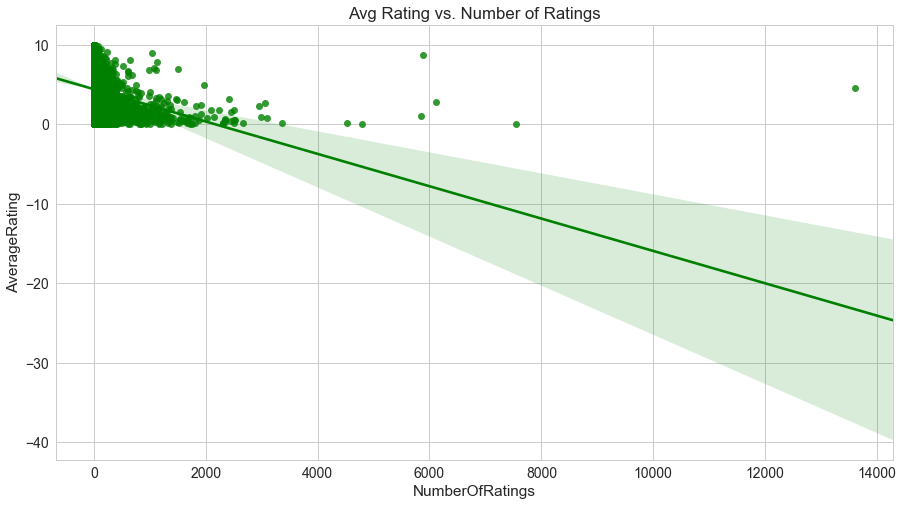

In [20]:
plt.subplots(figsize = (15,8))
sns.regplot(x="NumberOfRatings", y="AverageRating", color = 'green', data=user_df).set_title("Avg Rating vs. Number of Ratings")

Let us check the users which are extreme points above and have more than 6000 ratings yet not a great average rating.

In [21]:
# Filtering out the Users and getting info from the Users dataset
extrm_user = user_df[(user_df['NumberOfRatings']>6000)]['UserID']
users[users['UserID'].isin(extrm_user)]

,UserID,Location,Age
11675,11676,"n/a, n/a, n/a",NaN
153661,153662,"ft. stewart, georgia, usa",44.0
198710,198711,"little canada, minnesota, usa",62.0


Let us list some of the top 5 users and books (based on mean rating and count of ratings).

In [22]:
# Sort the books with average rating first
isbn_df.sort_values(['AverageRating','NumberOfRatings'],ascending=False).head()

,ISBN,NumberOfRatings,AverageRating
88629,0395193958,6,10.0
7449,0060280034,4,10.0
13802,006440546X,4,10.0
84218,0393048470,4,10.0
97071,0439042445,4,10.0


In [23]:
# Sort the books with number of ratings first
isbn_df.sort_values(['NumberOfRatings','AverageRating'],ascending=False).head()

,ISBN,NumberOfRatings,AverageRating
247408,0971880107,2502,1.019584
47371,0316666343,1295,4.468726
83359,0385504209,883,4.652322
9637,0060928336,732,3.448087
41007,0312195516,723,4.334716


In [33]:
pd.set_option('display.max_colwidth', -1)

import numpy as np
from io import BytesIO
from PIL import Image
from base64 import b64encode
from matplotlib import cm
from matplotlib.colors import Normalize
   
def matshow_func(x):
    b = BytesIO()  
    norm = Normalize(clip=True)         
    if not np.ma.isMaskedArray(x):
        x = np.ma.array(x,mask = np.isnan(x))            
    c = cm.jet(norm(x), bytes=True)
    Image.fromarray(c).save(b, format='png')
    return '<img alt="2d array" src="data:image/png;base64,' + b64encode(b.getvalue()) + '" />'
   
matshow_func.escape = False  # This prevents the "<" tags getting escaped
matshow_func.justify = 'all' # This prevents the long string of data getting abrieviated with "..."

In [38]:
# Append and get the info from the books dataset
top_books = isbn_df.sort_values(['AverageRating','NumberOfRatings'],ascending=False).head().append(isbn_df.sort_values(['NumberOfRatings','AverageRating'],ascending=False).head())
top_books.merge(books, how="left", on="ISBN")

,ISBN,NumberOfRatings,AverageRating,Title,Author,YrOfPublication,Publisher,ImageUrlS,ImageUrlM,ImageUrlL
0,0395193958,6,10.000000,The Lord of the Rings (Leatherette Collector's Edition),J. R. R. Tolkien,1974,Houghton Mifflin Company,http://images.amazon.com/images/P/0395193958.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0395193958.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0395193958.01.LZZZZZZZ.jpg
1,0060280034,4,10.000000,Dinotopia: A Land Apart from Time (Dinotopia),James Gurney,1998,HarperCollins,http://images.amazon.com/images/P/0060280034.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060280034.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060280034.01.LZZZZZZZ.jpg
2,006440546X,4,10.000000,Betsy and Joe (Betsy &amp; Tacy),Maud Hart Lovelace,1995,HarperTrophy,http://images.amazon.com/images/P/006440546X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/006440546X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/006440546X.01.LZZZZZZZ.jpg
3,0393048470,4,10.000000,The Annotated Alice: The Definitive Edition,Lewis Carroll,1999,W.W. Norton &amp; Company,http://images.amazon.com/images/P/0393048470.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393048470.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393048470.01.LZZZZZZZ.jpg
4,0439042445,4,10.000000,I Spy Treasure Hunt: A Book of Picture Riddles (I Spy Books),Walter Wick,1999,Scholastic,http://images.amazon.com/images/P/0439042445.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0439042445.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0439042445.01.LZZZZZZZ.jpg
5,0971880107,2502,1.019584,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0971880107.01.LZZZZZZZ.jpg
6,0316666343,1295,4.468726,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
7,0385504209,883,4.652322,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0385504209.01.LZZZZZZZ.jpg
8,0060928336,732,3.448087,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060928336.01.LZZZZZZZ.jpg
9,0312195516,723,4.334716,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0312195516.01.LZZZZZZZ.jpg


In [26]:
# Sort the users with average rating first
user_df.sort_values(['AverageRating','NumberOfRatings'],ascending=False).head()

,UserID,NumberOfRatings,AverageRating
29667,78469,18,10.0
97043,256765,16,10.0
32693,86263,12,10.0
95540,252829,10,10.0
90461,239873,9,10.0


In [27]:
# Sort the users with number of ratings first
user_df.sort_values(['NumberOfRatings','AverageRating'],ascending=False).head()

,UserID,NumberOfRatings,AverageRating
4213,11676,13602,4.564917
74815,198711,7550,0.016291
58113,153662,6109,2.786872
37356,98391,5891,8.728230
13576,35859,5850,1.075897


In [28]:
# Append and get the info from the users dataset
top_users = user_df.sort_values(['AverageRating','NumberOfRatings'],ascending=False).head().append(user_df.sort_values(['NumberOfRatings','AverageRating'],ascending=False).head())
top_users.merge(users, how="left", on="UserID")

,UserID,NumberOfRatings,AverageRating,Location,Age
0,78469,18,10.000000,"centerville, georgia, usa",NaN
1,256765,16,10.000000,"n/a, n/a, usa",NaN
2,86263,12,10.000000,"rensselaer, new york, usa",NaN
3,252829,10,10.000000,"sierra vista, arizona, usa",18.0
4,239873,9,10.000000,"san jose, california, usa",NaN
5,11676,13602,4.564917,"n/a, n/a, n/a",NaN
6,198711,7550,0.016291,"little canada, minnesota, usa",62.0
7,153662,6109,2.786872,"ft. stewart, georgia, usa",44.0
8,98391,5891,8.728230,"morrow, georgia, usa",52.0
9,35859,5850,1.075897,"duluth, minnesota, usa",NaN


### Building the Recommender system

Let us build a simple recommender system using SVD algorithm. But we will filter the dataset to check the performance of the algorithm and then later train it on the entire dataset.

In [69]:
# Loading the dataset into surprise
reader = Reader()

data = Dataset.load_from_df(ratings[['UserID', 'ISBN', 'Rating']][ratings['Rating']>0], reader)
data.split(n_folds=3)

# Applying the SVD algorithm
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/anaconda/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/anaconda/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 3.1844
MAE:  2.7645
------------
Fold 2
RMSE: 3.1889
MAE:  2.7701
------------
Fold 3
RMSE: 3.1913
MAE:  2.7707
------------
------------
Mean RMSE: 3.1882
Mean MAE : 2.7685
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [2.7645414199578529,
                             2.7701079949647904,
                             2.7707219497612257],
                            'rmse': [3.184447207545551,
                             3.1888861897693426,
                             3.1912767387375229]})

In [66]:
# Train the model
trainset = data.build_full_trainset()
svd.fit(trainset)

# Predict the rating for a particular user and book
UserID = str(22222)
ISBN = str(111111)
Rating = 8
print(svd.predict(UserID, ISBN, Rating))

user: 22222      item: 111111     r_ui = 8.00   est = 5.00   {'was_impossible': False}


Let's see what a particular user liked in the past.

In [67]:
df = ratings[(ratings['UserID'] == 278221) & (ratings['Rating'] == 10)]
df = df.merge(books[['ISBN','Title','Author']], how="left", on="ISBN")
print(df)
df = df.set_index('ISBN')

   UserID        ISBN  Rating  \
0  278221  0316031038      10   
1  278221  0316031046      10   
2  278221  0316031054      10   
3  278221  0316779032      10   
4  278221  0316779075      10   
5  278221  0671027441      10   
6  278221  0871237954      10   
7  278221  1556612257      10   
8  278221  1589196635      10   
9  278221  1889613010      10   

                                               Title             Author  
0            Jo's Boys : From the Original Publisher  Louisa May Alcott  
1                                         Little Men  Louisa May Alcott  
2         Little Women : From the Original Publisher  Louisa May Alcott  
3  The Discipline Book: How to Have a Better-Beha...             Martha  
4  The Birth Book : Everything You Need to Know t...       Martha Sears  
5  Natural Family Living : The Mothering Magazine...       Peggy O'Mara  
6      When Comes the Spring (Canadian West, Book 2)        Janette Oke  
7          A Woman Named Damaris (Women of t

Let us predict which books user 278221 would like to read in future.

In [68]:
user_p = books.copy()
user_p = user_p.reset_index()

# getting full dataset
data = Dataset.load_from_df(ratings, reader)
trainset = data.build_full_trainset()
svd.fit(trainset)

user_p['Estimate_Score'] = user_p['ISBN'].apply(lambda x: svd.predict(278221, x).est)

user_p = user_p.drop('ISBN', axis = 1)

user_p = user_p.sort_values('Estimate_Score', ascending=False)

print(user_p.head(10))

         index                                              Title  \
181149  181149                                     SATELLITE DOWN   
86612    86612                                Dancing in the Dark   
86609    86609                            CLOUD CHAMBER : A Novel   
244153  244153              The Frog Prince (Fairy Tale Classics)   
244155  244155  Return of the Ninja (Choose Your Own Adventure...   
86605    86605                             Despistes y franquezas   
86604    86604                 La Vida Sexual de Catherine Millet   
86601    86601                                           Tombuctu   
86599    86599  Isla Africa (Biblioteca Breve (Barcelona, Spai...   
86598    86598                       LA Isla Del Fin De LA Suerte   

                       Author YrOfPublication  \
181149             Rob Thomas            1998   
86612   Rosalie Ferrer Kramer            2001   
86609          Michael Dorris            1997   
244153         Brothers Grimm            198